# Petar i vuk: Uvod u učenje pojačanjem

U ovom vodiču naučit ćemo kako primijeniti učenje pojačanjem na problem pronalaženja puta. Postavka je inspirirana glazbenom bajkom [Petar i vuk](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) ruskog skladatelja [Sergeja Prokofjeva](https://en.wikipedia.org/wiki/Sergei_Prokofiev). To je priča o mladom pioniru Petru, koji hrabro izlazi iz svoje kuće na šumsku čistinu kako bi lovio vuka. Trenirat ćemo algoritme strojnog učenja koji će pomoći Petru da istraži okolno područje i izgradi optimalnu kartu za navigaciju.

Prvo, uvezimo nekoliko korisnih biblioteka:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Pregled učenja putem pojačanja

**Učenje putem pojačanja** (RL) je tehnika učenja koja nam omogućuje da naučimo optimalno ponašanje **agenta** u nekom **okruženju** provođenjem mnogih eksperimenata. Agent u ovom okruženju treba imati neki **cilj**, definiran pomoću **funkcije nagrade**.

## Okruženje

Radi jednostavnosti, zamislimo da je Peterov svijet kvadratna ploča veličine `width` x `height`. Svaka ćelija na ovoj ploči može biti:
* **tlo**, po kojem Peter i druga bića mogu hodati
* **voda**, po kojoj očito ne možete hodati
* **stablo** ili **trava** - mjesto gdje se možete odmoriti
* **jabuka**, koja predstavlja nešto što bi Peter rado pronašao kako bi se nahranio
* **vuk**, koji je opasan i treba ga izbjegavati

Za rad s okruženjem definirat ćemo klasu pod nazivom `Board`. Kako ne bismo previše zatrpali ovaj bilježnik, sav kod za rad s pločom premjestili smo u zasebni modul `rlboard`, koji ćemo sada uvesti. Možete pogledati unutar ovog modula za više detalja o unutarnjem funkcioniranju implementacije.


In [2]:
from rlboard import *

Hajdemo sada stvoriti nasumičnu ploču i vidjeti kako izgleda:


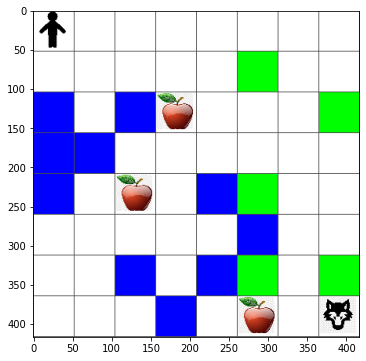

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Akcije i Pravila

U našem primjeru, Petrov cilj je pronaći jabuku, dok izbjegava vuka i druge prepreke. Da bi to postigao, može se jednostavno kretati dok ne pronađe jabuku. Dakle, na bilo kojoj poziciji može birati između sljedećih akcija: gore, dolje, lijevo i desno. Te ćemo akcije definirati kao rječnik i povezati ih s parovima odgovarajućih promjena koordinata. Na primjer, kretanje desno (`R`) odgovaralo bi paru `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategija našeg agenta (Petar) definirana je takozvanom **politikom**. Razmotrimo najjednostavniju politiku nazvanu **slučajna šetnja**.

## Slučajna šetnja

Najprije riješimo naš problem implementacijom strategije slučajne šetnje.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Hajdemo provesti eksperiment slučajne šetnje nekoliko puta i vidjeti prosječan broj poduzetih koraka:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funkcija nagrađivanja

Kako bismo učinili našu politiku inteligentnijom, moramo razumjeti koji su potezi "bolji" od drugih.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Učenje

Izgradite Q-Tablicu, ili višedimenzionalni niz. Budući da naša ploča ima dimenzije `width` x `height`, Q-Tablicu možemo predstaviti numpy nizom oblika `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Proslijedite Q-Tablicu funkciji za crtanje kako biste vizualizirali tablicu na ploči:


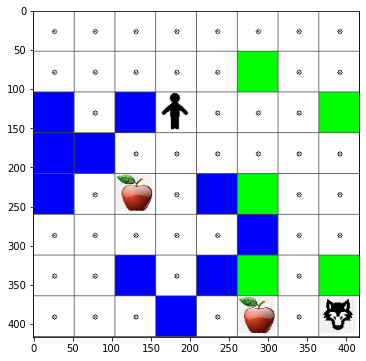

In [9]:
m.plot(Q)

## Suština Q-Learninga: Bellmanova jednadžba i algoritam učenja

Napišite pseudo-kod za naš algoritam učenja:

* Inicijalizirajte Q-Tablicu Q s jednakim vrijednostima za sva stanja i akcije
* Postavite stopu učenja $\alpha\leftarrow 1$
* Ponavljajte simulaciju mnogo puta
   1. Započnite na nasumičnoj poziciji
   1. Ponavljajte
        1. Odaberite akciju $a$ u stanju $s$
        2. Izvršite akciju prelaskom u novo stanje $s'$
        3. Ako naiđemo na uvjet kraja igre ili je ukupna nagrada premala - izađite iz simulacije  
        4. Izračunajte nagradu $r$ u novom stanju
        5. Ažurirajte Q-Funkciju prema Bellmanovoj jednadžbi: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Ažurirajte ukupnu nagradu i smanjite $\alpha$.

## Eksploatacija vs. Istraživanje

Najbolji pristup je balansiranje između istraživanja i eksploatacije. Kako više učimo o našem okruženju, vjerojatnije ćemo slijediti optimalan put, no povremeno odabrati neistraženi put.

## Python Implementacija

Sada smo spremni implementirati algoritam učenja. Prije toga, trebamo funkciju koja će pretvoriti proizvoljne brojeve u Q-Tablici u vektor vjerojatnosti za odgovarajuće akcije:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Dodajemo malu količinu `eps` izvornom vektoru kako bismo izbjegli dijeljenje s 0 u početnom slučaju, kada su sve komponente vektora identične.

Stvarni algoritam učenja izvodit ćemo kroz 5000 eksperimenata, također nazvanih **epohe**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Nakon izvršavanja ovog algoritma, Q-Tablica bi trebala biti ažurirana vrijednostima koje definiraju privlačnost različitih akcija u svakom koraku. Vizualizirajte tablicu ovdje:


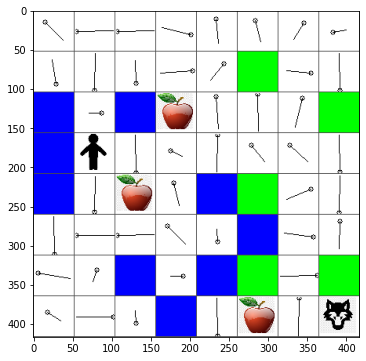

In [12]:
m.plot(Q)

## Provjera politike

Budući da Q-Tablica prikazuje "privlačnost" svake akcije u svakom stanju, vrlo je jednostavno koristiti je za definiranje učinkovitog kretanja u našem svijetu. U najjednostavnijem slučaju, možemo jednostavno odabrati akciju koja odgovara najvećoj vrijednosti u Q-Tablici:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ako pokušate kod iznad nekoliko puta, možda ćete primijetiti da se ponekad jednostavno "zaglavi", i morate pritisnuti gumb STOP u bilježnici kako biste ga prekinuli.

> **Zadatak 1:** Izmijenite funkciju `walk` kako biste ograničili maksimalnu duljinu puta na određeni broj koraka (recimo, 100), i promatrajte kako kod iznad povremeno vraća ovu vrijednost.

> **Zadatak 2:** Izmijenite funkciju `walk` tako da se ne vraća na mjesta na kojima je već bio ranije. Ovo će spriječiti da se `walk` vrti u krug, međutim, agent i dalje može završiti "zarobljen" na lokaciji s koje ne može pobjeći.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


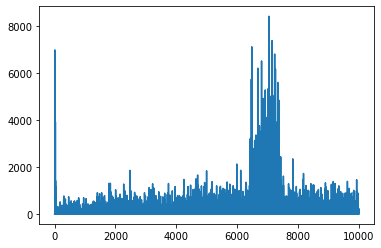

In [15]:
plt.plot(lpath)

Ono što ovdje vidimo je da se u početku prosječna duljina puta povećala. To je vjerojatno zbog činjenice da, kada ne znamo ništa o okruženju, skloni smo zapasti u loša stanja, poput vode ili vuka. Kako učimo više i počinjemo koristiti to znanje, možemo dulje istraživati okruženje, ali još uvijek ne znamo dobro gdje se nalaze jabuke.

Kada naučimo dovoljno, agentu postaje lakše postići cilj, i duljina puta počinje se smanjivati. Međutim, još uvijek smo otvoreni za istraživanje, pa često odstupamo od najboljeg puta i istražujemo nove opcije, što čini put duljim od optimalnog.

Ono što također primjećujemo na ovom grafu je da se u jednom trenutku duljina naglo povećala. To ukazuje na stohastičku prirodu procesa, i da u nekom trenutku možemo "pokvariti" koeficijente Q-Tablice, prepisujući ih novim vrijednostima. To bi idealno trebalo minimizirati smanjenjem stope učenja (tj. prema kraju treninga prilagođavamo vrijednosti Q-Tablice samo malim iznosom).

Sveukupno, važno je zapamtiti da uspjeh i kvaliteta procesa učenja značajno ovise o parametrima, poput stope učenja, smanjenja stope učenja i faktora diskonta. Ti se parametri često nazivaju **hiperparametri**, kako bi se razlikovali od **parametara** koje optimiziramo tijekom treninga (npr. koeficijenti Q-Tablice). Proces pronalaženja najboljih vrijednosti hiperparametara naziva se **optimizacija hiperparametara**, i zaslužuje zasebnu temu.


## Vježba
#### Realističniji svijet Petra i vuka

U našoj situaciji, Petar se mogao kretati gotovo bez umaranja ili osjećaja gladi. U realističnijem svijetu, morao bi s vremena na vrijeme sjesti i odmoriti se, kao i nahraniti se. Učinimo naš svijet realističnijim implementirajući sljedeća pravila:

1. Kretanjem s jednog mjesta na drugo, Petar gubi **energiju** i dobiva određeni stupanj **umora**.
2. Petar može dobiti više energije jedući jabuke.
3. Petar se može riješiti umora odmarajući se ispod stabla ili na travi (tj. ulaskom na polje ploče sa stablom ili travom - zeleno polje).
4. Petar mora pronaći i ubiti vuka.
5. Kako bi ubio vuka, Petar mora imati određene razine energije i umora, inače gubi bitku.

Prilagodite funkciju nagrade prema pravilima igre, pokrenite algoritam za učenje pojačanjem kako biste naučili najbolju strategiju za pobjedu u igri i usporedite rezultate slučajnog kretanja s vašim algoritmom u smislu broja dobivenih i izgubljenih igara.

> **Napomena**: Možda ćete morati prilagoditi hiperparametre kako bi sve funkcioniralo, posebno broj epoha. Budući da je uspjeh u igri (borba s vukom) rijedak događaj, možete očekivati znatno dulje vrijeme treniranja.



---

**Odricanje od odgovornosti**:  
Ovaj dokument je preveden korištenjem AI usluge za prevođenje [Co-op Translator](https://github.com/Azure/co-op-translator). Iako nastojimo osigurati točnost, imajte na umu da automatski prijevodi mogu sadržavati pogreške ili netočnosti. Izvorni dokument na izvornom jeziku treba smatrati mjerodavnim izvorom. Za ključne informacije preporučuje se profesionalni prijevod od strane stručnjaka. Ne preuzimamo odgovornost za bilo kakve nesporazume ili pogrešne interpretacije proizašle iz korištenja ovog prijevoda.
